# Checkouts
This is for looking at the station checkout data that Kevin sent us.

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import csv
from collections import defaultdict

#This lets us zoom in and move around graphs in this notebook
%matplotlib widget

In [2]:
#Get the streets and buildings that we'll want to see on maps:
buildings = None
with open('buildings_cu.json') as f:
    buildings = json.loads(f.read())

streets = None
with open('streets_near_campus.json') as f: #these will have duplicates. There are multiple entries for roads like Broadway
    streets = json.loads(f.read())

In [3]:
print("CU Buildings: {}".format(len(buildings)))
print("Near Campus Streets: {} (there are probably duplicates)".format(len(streets)))

CU Buildings: 423
Near Campus Streets: 806 (there are probably duplicates)


In [4]:
#Get station information (latitude and longitude, names)
stations = None
with open('station_information.json') as f: #TODO: Use urlopen to get the current one?
    stations = json.loads(f.read())['data']['stations']

print("There are {} Boulder BCycle Stations".format(len(stations)))

#Do some convenience stuff to stations:

#make it a dictionary with ids as keys
temp = stations
stations = {}
for station in temp:
    stations[station['station_id']] = station

#For convenience:
def GetStationID(stationName):
    for stationID in stations:
        if stations[stationID]['name'] == stationName:
            return stationID
    return None

There are 45 Boulder BCycle Stations


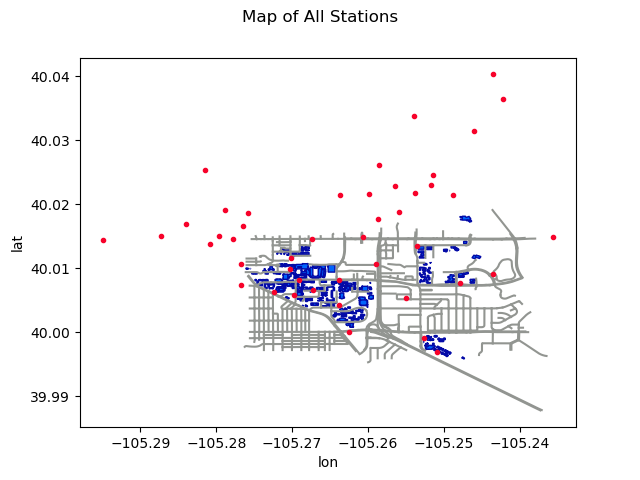

In [5]:
lats = [stations[station]['lat'] for station in stations]
lons = [stations[station]['lon'] for station in stations]

#plot
plt.figure()
plt.suptitle('Map of All Stations')

for building in buildings:
    x = [pair[0] for pair in building['geometry']['coordinates'][0]]
    y = [pair[1] for pair in building['geometry']['coordinates'][0]]

    plt.fill(x, y, facecolor='xkcd:bright blue', edgecolor='xkcd:cobalt blue')

for street in streets:
    x = [pair[0] for pair in street['geometry']['coordinates']]
    y = [pair[1] for pair in street['geometry']['coordinates']]

    plt.plot(x, y, color='xkcd:grey')

plt.plot(lons, lats, '.', color='xkcd:cherry red')
    
plt.ylabel('lat')
plt.xlabel('lon')
plt.ticklabel_format(useOffset=False)

plt.show()

In [6]:
checkouts = {}
with open('Boulder BCycle Kiosk Checkout Report December 2021-February 2022.csv', newline='') as f:
    reader = csv.reader(f)
    lines = [row for row in reader]
    
    #for each row
    #Ignore the first row with the labels
    for i in range(1, len(lines)):
        stationID = GetStationID(lines[i][0])
        
        #Make sure we actually found the id of the station we're looking for
        if stationID is not None:
            stations[stationID]['found_checkouts_data'] = True
            stations[stationID]['total_docks'] = int(lines[i][1])
            
            checkouts[stationID] = {}
            checkouts[stationID]['total'] = int(lines[i][2])
            checkouts[stationID]['total_per_dock'] = float(lines[i][3])
            checkouts[stationID]['avg_per_day'] = float(lines[i][4])
            checkouts[stationID]['avg_per_dock_per_day'] = float(lines[i][5])
        else:
            print("Couldn't find ID for station: {}".format(lines[i][0]))

Couldn't find ID for station: 11th & Pearl
Couldn't find ID for station: 38th & Arapahoe
Couldn't find ID for station: Fisher Drive and Exposition Drive
Couldn't find ID for station: Boulder Junction North
Couldn't find ID for station: 20th & Pearl


In [7]:
for stationID in stations:
    if stations[stationID].get('found_checkouts_data') == None:
        print("Didn't find data for station: {} - \'{}\'".format(stationID, stations[stationID]))

Didn't find data for station: bcycle_boulder_3876 - '{'lon': -105.24876, 'lat': 40.02145, 'rental_uris': {'ios': 'https://www.bcycle.com/applink?system_id=bcycle_boulder&station_id=bcycle_boulder_3876&platform=iOS', 'android': 'https://www.bcycle.com/applink?system_id=bcycle_boulder&station_id=bcycle_boulder_3876&platform=android'}, '_bcycle_station_type': 'Kiosk and Station', 'address': '3333 Walnut St', 'name': '33rd & Walnut', 'station_id': 'bcycle_boulder_3876'}'


### Map of Stations by Checkouts Per Day Per Dock

This lets us see which stations are getting used more or less than we'd expect based on their size. Those that are used more or less often than we'd expect might be more volatile (meaning they might be more likely to always be either completely full or completely empty), and we might want to look into them.

If a station is overused, we could try to figure out where the people who are using it need to go, and add stations to give them a more direct way of doing so. (for example, say the will vill and c4c stations are overused. If we find out that a lot of those people really want to go from will vill to farrand field, and the c4c just happens to be the nearest station, we could add a station at farrand field, and that would take some pressure of the c4c station.)

min, max checkouts per dock per day: [0.03, 4.54]


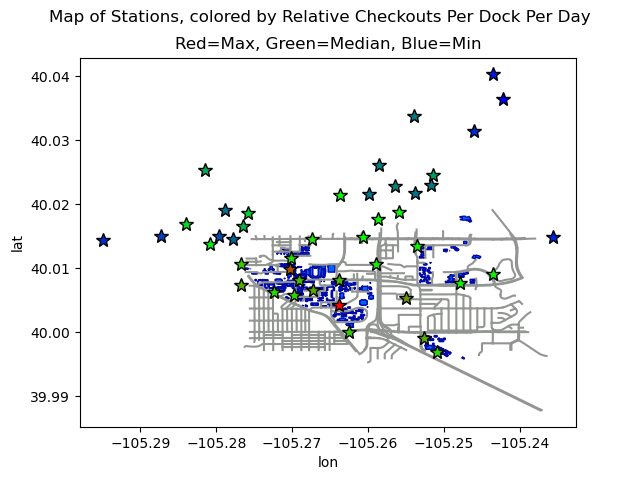

In [22]:
maxPerDockPerDay = max([checkouts[stationID]['avg_per_dock_per_day'] for stationID in checkouts])
minPerDockPerDay = min([checkouts[stationID]['avg_per_dock_per_day'] for stationID in checkouts])

print("min, max checkouts per dock per day: [{}, {}]".format(minPerDockPerDay, maxPerDockPerDay))

#plot
plt.figure()
plt.suptitle('Map of Stations, colored by Relative Checkouts Per Dock Per Day')
plt.title('Red=Max, Green=Median, Blue=Min')

for building in buildings:
    for element in building['geometry']['coordinates']:
        x = [pair[0] for pair in element]
        y = [pair[1] for pair in element]

    plt.fill(x, y, facecolor='xkcd:bright blue', edgecolor='xkcd:cobalt blue')

for street in streets:
    x = [pair[0] for pair in street['geometry']['coordinates']]
    y = [pair[1] for pair in street['geometry']['coordinates']]

    plt.plot(x, y, color='xkcd:grey')


medianPerDockPerDay = np.median([checkouts[stationID]['avg_per_dock_per_day'] for stationID in checkouts])
for stationID in checkouts:
    r = 0 if checkouts[stationID]['avg_per_dock_per_day'] < medianPerDockPerDay else (checkouts[stationID]['avg_per_dock_per_day']-medianPerDockPerDay)/(maxPerDockPerDay-medianPerDockPerDay)
    b = 0 if checkouts[stationID]['avg_per_dock_per_day'] > medianPerDockPerDay else (medianPerDockPerDay-checkouts[stationID]['avg_per_dock_per_day'])/(medianPerDockPerDay-minPerDockPerDay)
    g = 1-b if checkouts[stationID]['avg_per_dock_per_day'] < medianPerDockPerDay else 1-r
    
    c = (r, g, b)
    plt.plot(stations[stationID]['lon'], stations[stationID]['lat'], '*', color=c, markeredgecolor='black', markersize=10, markeredgewidth=1)
    
plt.ylabel('lat')
plt.xlabel('lon')
plt.ticklabel_format(useOffset=False)

plt.show()

min, max checkouts per dock per day: [0.03, 4.54]


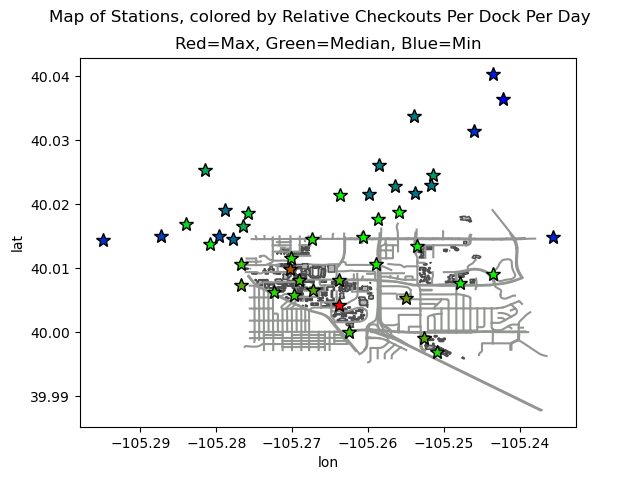

In [9]:
maxPerDockPerDay = max([checkouts[stationID]['avg_per_dock_per_day'] for stationID in checkouts])
minPerDockPerDay = min([checkouts[stationID]['avg_per_dock_per_day'] for stationID in checkouts])

print("min, max checkouts per dock per day: [{}, {}]".format(minPerDockPerDay, maxPerDockPerDay))

#plot
plt.figure()
plt.suptitle('Map of Stations, colored by Relative Checkouts Per Dock Per Day')
plt.title('Red=Max, Green=Median, Blue=Min')

for building in buildings:
    x = [pair[0] for pair in building['geometry']['coordinates'][0]]
    y = [pair[1] for pair in building['geometry']['coordinates'][0]]

    plt.fill(x, y, facecolor=(0.7,0.7,0.7), edgecolor=(0.3, 0.3, 0.3))

for street in streets:
    x = [pair[0] for pair in street['geometry']['coordinates']]
    y = [pair[1] for pair in street['geometry']['coordinates']]

    plt.plot(x, y, color='xkcd:grey')


medianPerDockPerDay = np.median([checkouts[stationID]['avg_per_dock_per_day'] for stationID in checkouts])
for stationID in checkouts:
    r = 0 if checkouts[stationID]['avg_per_dock_per_day'] < medianPerDockPerDay else (checkouts[stationID]['avg_per_dock_per_day']-medianPerDockPerDay)/(maxPerDockPerDay-medianPerDockPerDay)
    b = 0 if checkouts[stationID]['avg_per_dock_per_day'] > medianPerDockPerDay else (medianPerDockPerDay-checkouts[stationID]['avg_per_dock_per_day'])/(medianPerDockPerDay-minPerDockPerDay)
    g = 1-b if checkouts[stationID]['avg_per_dock_per_day'] < medianPerDockPerDay else 1-r
    
    c = (r, g, b)
    plt.plot(stations[stationID]['lon'], stations[stationID]['lat'], '*', color=c, markeredgecolor='black', markersize=10, markeredgewidth=1)
    
plt.ylabel('lat')
plt.xlabel('lon')
plt.ticklabel_format(useOffset=False)

plt.show()

min, max checkouts per dock per day: [0.03, 4.54]


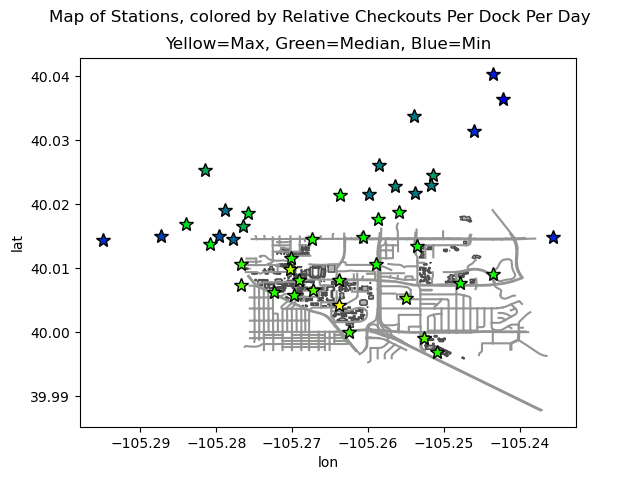

In [26]:
maxPerDockPerDay = max([checkouts[stationID]['avg_per_dock_per_day'] for stationID in checkouts])
minPerDockPerDay = min([checkouts[stationID]['avg_per_dock_per_day'] for stationID in checkouts])

print("min, max checkouts per dock per day: [{}, {}]".format(minPerDockPerDay, maxPerDockPerDay))

#plot
plt.figure()
plt.suptitle('Map of Stations, colored by Relative Checkouts Per Dock Per Day')
plt.title('Yellow=Max, Green=Median, Blue=Min')

for building in buildings:
    for element in building['geometry']['coordinates']:
        x = [pair[0] for pair in element]
        y = [pair[1] for pair in element]

    plt.fill(x, y, facecolor=(0.7,0.7,0.7), edgecolor=(0.3, 0.3, 0.3))

for street in streets:
    x = [pair[0] for pair in street['geometry']['coordinates']]
    y = [pair[1] for pair in street['geometry']['coordinates']]

    plt.plot(x, y, color='xkcd:grey')


medianPerDockPerDay = np.median([checkouts[stationID]['avg_per_dock_per_day'] for stationID in checkouts])
for stationID in checkouts:
    #r = 0 if checkouts[stationID]['avg_per_dock_per_day'] < medianPerDockPerDay else (checkouts[stationID]['avg_per_dock_per_day']-medianPerDockPerDay)/(maxPerDockPerDay-medianPerDockPerDay)
    b = 0 if checkouts[stationID]['avg_per_dock_per_day'] > medianPerDockPerDay else (medianPerDockPerDay-checkouts[stationID]['avg_per_dock_per_day'])/(medianPerDockPerDay-minPerDockPerDay)
    r = 0 if checkouts[stationID]['avg_per_dock_per_day'] < medianPerDockPerDay else (checkouts[stationID]['avg_per_dock_per_day']-medianPerDockPerDay)/(maxPerDockPerDay-medianPerDockPerDay)
    g = 1-b if checkouts[stationID]['avg_per_dock_per_day'] < medianPerDockPerDay else 1
    
    c = (r, g, b)
    plt.plot(stations[stationID]['lon'], stations[stationID]['lat'], '*', color=c, markeredgecolor='black', markersize=10, markeredgewidth=1)
    
plt.ylabel('lat')
plt.xlabel('lon')
plt.ticklabel_format(useOffset=False)

plt.show()